<center><h1>Final Project</h1></center>
<center><h3>Methods in Quantitative Biology</h3></center>

Given a 2s audio file, can we determine the timestamps where bowel sounds occur in the file?

# Data Loading

First, let us load the data. There's not too much data, so we can probably load all the data into memory. We'll make a data object to store both the data and its annotations in the same object for convenience.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.typing as npt
import random
from scipy.io import wavfile
from dataclasses import dataclass
from enum import Enum
from scipy.fft import fft, fftfreq, irfft
from scipy.signal import butter, lfilter, freqz
import scipy.signal as signal

There is an index of all the audio files stored in `data/files.csv`:

In [2]:
data_index = pd.read_csv("data/files.csv")

In [3]:
data_index.head()

,filename,train/test,sounds_amount
0,423_c.wav,train,24
1,113_c.wav,train,6
2,377_c.wav,train,5
3,25_g.wav,train,4
4,112_c.wav,train,9


We can iterate through each row and load each file into memory. We will keep the annotations. First we will define an enum corresponding to the train/test annotation split on each sample:

In [4]:
class Split(Enum):
    TRAIN = 0
    TEST = 1

We will use a dataclass to hold the data for a single audio sample.

In [5]:
@dataclass
class Sample:
    filename: str
    rate: int
    data: npt.NDArray
    split: Split
    sounds_amount: int
    labels: pd.DataFrame

We can now read all the files into memory by iterating through each row.

In [6]:
samples = []
for row in data_index.itertuples():
    rate, data = wavfile.read(f"data/{row.filename}")
    labels = pd.read_csv(f"""data/{row.filename.replace(".wav", ".csv")}""")
    split = Split.TRAIN if row._2 == "train" else Split.TEST
    sample = Sample(row.filename, rate, data, split, row.sounds_amount, labels)
    samples.append(sample)

For the purposes of separation and evaluation, we will split the data into a training and test split according to their labels in the original data:

In [7]:
samples_train = [sample for sample in samples if sample.split == Split.TRAIN]
samples_test = [sample for sample in samples if sample.split == Split.TEST]

Let's now define a function to plot a single sample, as well as its annotation data. This will be helpful for an initial visualization.

In [19]:
def plot_sample(sample: Sample, extra=None, ax=None):
    if ax is None:
        ax = plt.gca()
    time = np.arange(0, sample.data.shape[0]) / sample.rate 
    ax.plot(time, sample.data, label="original")
    if extra is not None:
        ax.plot(time, extra, label="extra")
    for row in sample.labels.itertuples():
        ax.axvspan(row.start, row.end, color='green', alpha=0.25)
    ax.set_title(f"{sample.filename}: {sample.sounds_amount} sounds")
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time (s)")
    return ax

Let's plot a random selection of 5 samples from the training data:

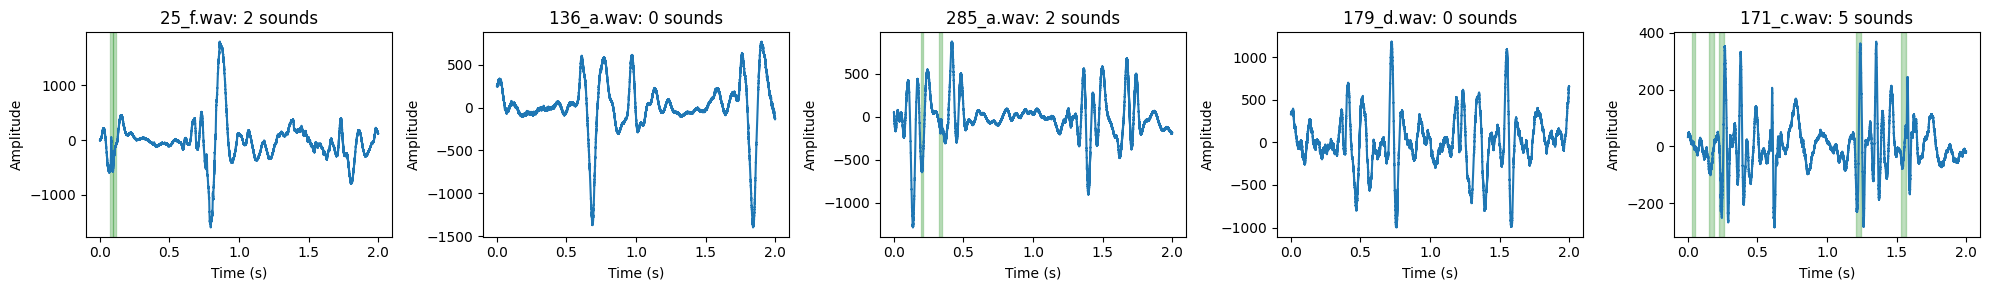

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
subset = random.sample(samples_train, 5)
for i, sample in enumerate(subset):
    plot_sample(sample, ax=ax[i])
plt.tight_layout()

Hm. It's not very obvious that the annotations actually correspond exactly to a meaningful position in the audio waveform. Maybe we need to try and apply a filter first. 

# Filtering

Let's first take an initial sample to work with.

<Axes: title={'center': '377_c.wav: 5 sounds'}, xlabel='Time (s)', ylabel='Amplitude'>

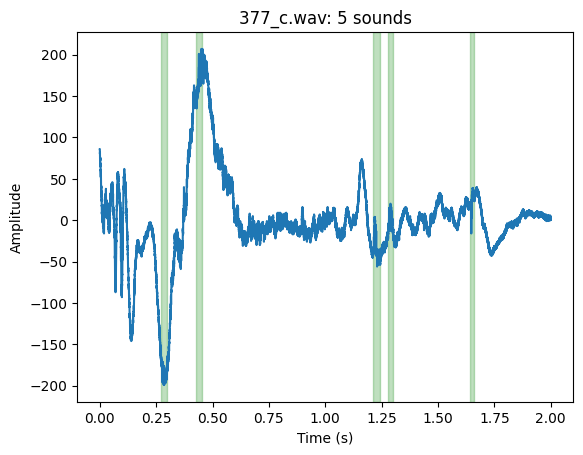

In [10]:
sample = samples_train[2]
plot_sample(sample)

We can look at the peaks in the frequency domain using a Fourier transform:

(-1000.0, 1000.0)

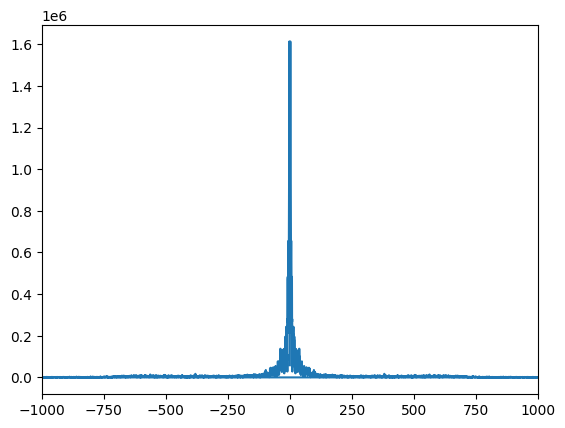

In [92]:
num_samples = len(sample.data)
yf = fft(sample.data)
xf = fftfreq(num_samples, 1 / sample.rate)
plt.plot(xf, np.abs(yf))
plt.xlim(-1000, 1000)

Let's try a simple band pass filter from 100-800Hz (based on this [separate paper](http://dx.doi.org/10.1109/JBHI.2022.3151927)):

In [94]:
sos =  butter(5, [100, 800], btype="band", output="sos", fs=sample.rate)

We can plot both the sample and its filtered waveform on the same plot:

In [95]:
def plot_sample_and_filtered(sample: Sample, ax=None):
    if ax is None:
        ax = plt.gca()
    plot_sample(sample, ax=ax, extra=signal.sosfilt(sos, sample.data))
    return ax

<Axes: title={'center': '377_c.wav: 5 sounds'}, xlabel='Time (s)', ylabel='Amplitude'>

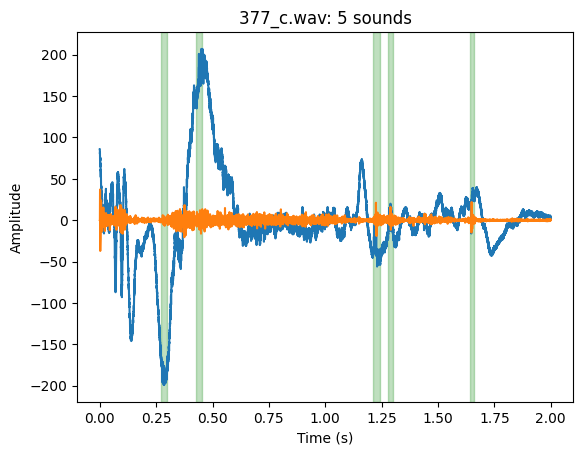

In [96]:
plot_sample_and_filtered(sample)

And just the filtered waveform:

In [97]:
def plot_filtered(sample: Sample, ax=None):
    if ax is None:
        ax = plt.gca()
    time = np.arange(0, sample.data.shape[0]) / sample.rate 
    filtered = signal.sosfilt(sos, sample.data)
    ax.plot(time, filtered, color="orange")
    for row in sample.labels.itertuples():
        ax.axvspan(row.start, row.end, color='green', alpha=0.25)
    ax.set_title(f"{sample.filename}: {sample.sounds_amount} sounds (Band-Pass Filtered)")
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time (s)")
    return ax

<Axes: title={'center': '377_c.wav: 5 sounds (Band-Pass Filtered)'}, xlabel='Time (s)', ylabel='Amplitude'>

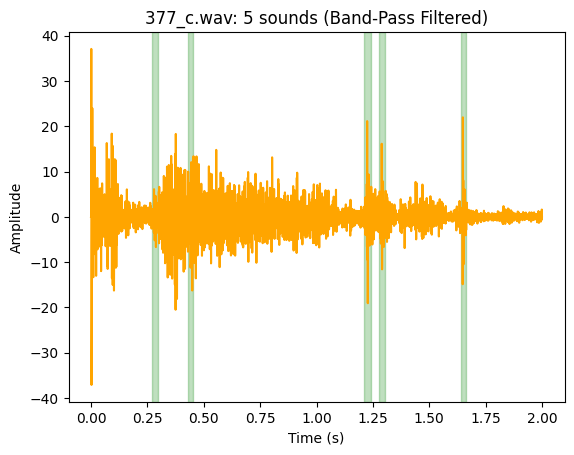

In [98]:
plot_filtered(sample)

Some of the peaks here do seem to align with the labelled annotations (and some don't).

We can have a look at this for a random selection of the data:

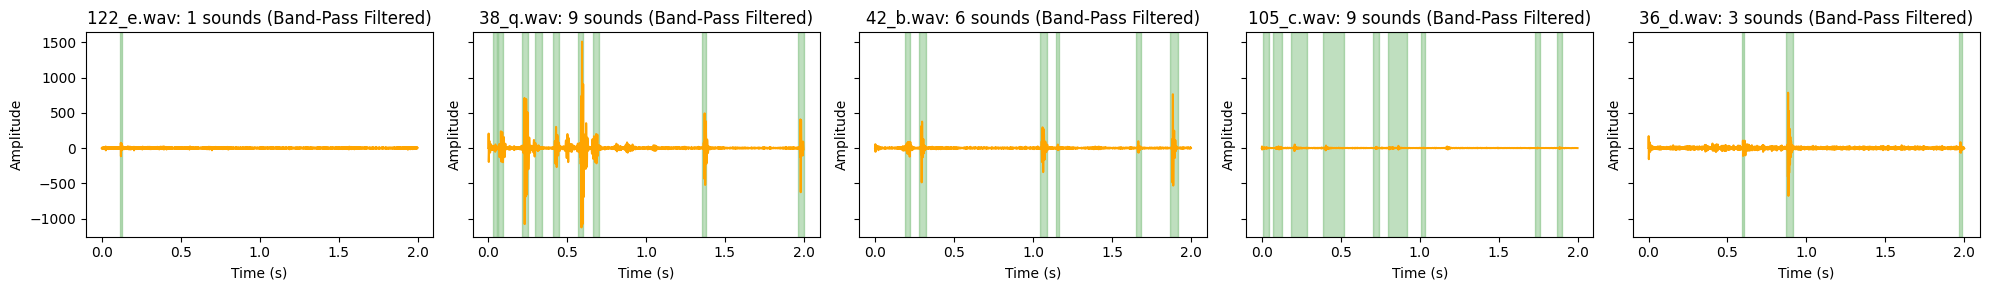

In [105]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3), sharey=True)
subset = random.sample(samples_train, 5)
for i, sample in enumerate(subset):
    plot_filtered(sample, ax=ax[i])
plt.tight_layout()

It's a bit variable. Are there any other heuristics we could use to identify bowel sounds? And another thing to consider - do we trust the labels?

Some ideas:
1. Don't trust peaks identified at the very start or end of the waveform - these may not be reliable. 
2. If there are a collection of peaks occuring close together, count them as one peak (this could probably be done with a convolve operation). 
3. Consider different band pass filter frequencies. 

After having a cusory listen to the bowel sounds, there definitely appear to be different types of sounds. It seems the easiest ones to identify (and the onest identified above) correspond to "beat"-like bowel sounds that occur at a defined, discrete point in time. 